# CatBoost Model

### Importing the libraries

In [1]:
# Base libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os.path
import pickle

In [2]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# Othe libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# import general custom data preprocessing functions
from General_Custom_Functions import *
General_Custom_Functions()


    Available General Custom Functions: 
    Check_Missing_Values(input_dataset)
    Move_Column_Last(input_dataset, target_variable)
    Check_Feature_Details(input_dataset, input_feature)
    Rearrange_Features(input_X_train, input_y_train)
    Check_Correlation(input_X_train)
    Check_Multicollinearity(input_X_train, numerical_feature_list)
    Make_Feature_Selection(input_X_train, input_y_train, max_validation_round)
    


### Importing the dataset

In [5]:
dataset = pd.read_csv('Cleaned_Dataset.csv')

In [6]:
imported_dataset = dataset.copy()

In [7]:
imported_dataset.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,Price
0,Toyota,Camry,SEDAN,Used,Silver,NaN,Automatic,Gasoline,San Antonio,78233,5507.0,4.0,2.0,27.0,38.0,1,38997.0
1,Toyota,Supra,COUPE,Used,Red,NaN,Automatic,Gasoline,San Antonio,78233,7094.0,4.0,2.0,25.0,32.0,1,51997.0
2,Ford,F250,TRUCKS,Used,White,Java,Automatic,Diesel,San Antonio,78219,19135.0,8.0,4.0,NaN,NaN,2,80500.0
3,Ford,Escape,SUV,Used,Blue,NaN,Automatic,Flexible Fuel,San Antonio,78233,26196.0,4.0,2.0,21.0,29.0,3,24997.0
4,Toyota,RAV4,SUV,Used,Purple,NaN,Automatic,Gasoline,San Antonio,78233,37486.0,4.0,2.0,23.0,30.0,4,29287.0


In [8]:
imported_dataset.shape

(19173, 17)

In [9]:
Check_Missing_Values(imported_dataset)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,396,2.07,object
Interior_Color,760,3.96,object
Transmission_Type,65,0.34,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,int64


In [10]:
# convert Zip_Code to object
imported_dataset['Zip_Code'] = imported_dataset['Zip_Code'].astype(str)

### Split the dataset into training and test dataset

In [11]:
# decoupling the dependent and independent variables
X = imported_dataset.iloc[:, :-1]
y = imported_dataset.iloc[:, -1]

In [12]:
# Train, Test split
# from now on till the model training we will only use X_train, y_train
# X_test and y_test will only be used during model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# backup copy the dataset for feature reference
backup_X_train = X_train.copy()
backup_X_test = X_test.copy()

In [13]:
X_train.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age
16668,Honda,Ridgeline,TRUCKS,Used,Silver,NaN,Automatic,Gasoline,Indianapolis,46227,22386.0,6.0,4.0,18.0,25.0,3
17823,BMW,430i,CONVERT,Used,White,Black Sensatec,Automatic,Gasoline,San Francisco,94103,588.0,4.0,2.0,24.0,33.0,1
11903,Ford,Fusion,SEDAN,Used,NaN,NaN,Automatic,Gasoline,Portland,97080,57249.0,4.0,2.0,23.0,34.0,4
4202,Hyundai,Elantra,SEDAN,Used,Blue,Gray,Automatic,Gasoline,Dallas,75006,18132.0,4.0,2.0,30.0,40.0,2
1593,GMC,Canyon,TRUCKS,Used,Brown,Cocoa/Dune,Automatic,Gasoline,San Diego,91950,27155.0,6.0,2.0,18.0,25.0,6


In [14]:
X_test.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age
11192,Subaru,Impreza,SEDAN,Certified,Blue,Black,Automatic,Gasoline,New York,11372,13903.0,4.0,4.0,28.0,38.0,3
17795,BMW,330i,SEDAN,Used,White,Cognac Vernasca Leather,Automatic,Gasoline,San Francisco,94103,9746.0,4.0,2.0,26.0,36.0,1
344,Ford,Edge,SUV,Used,Black,Dune,Automatic,Gasoline,San Antonio,78219,54033.0,4.0,2.0,20.0,29.0,4
16862,Chevrolet,Cruze,SEDAN,Used,Red,Jet Black,Automatic,Gasoline,Indianapolis,46038,29226.0,4.0,2.0,29.0,40.0,4
16575,Jeep,Grand Cherokee,SUV,Used,Gray,Black,Automatic,Gasoline,Phoenix,85014,50001.0,6.0,4.0,18.0,25.0,2


In [15]:
print(X_train.shape)
print(X_test.shape)

(15338, 16)
(3835, 16)


### Dealing with missing categorical features

In [16]:
Check_Missing_Values(X_train)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,317,2.07,object
Interior_Color,608,3.96,object
Transmission_Type,55,0.36,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,object


In [17]:
# replace missing categorical variables with the object Missing_Value_XYZ
X_train['Exterior_Color'] = X_train['Exterior_Color'].fillna('Missing_Value_EC')
X_train['Interior_Color'] = X_train['Interior_Color'].fillna('Missing_Value_IC')
X_train['Transmission_Type'] = X_train['Transmission_Type'].fillna('Missing_Value_TT')

### Dealing with missing numerical features

In [18]:
Check_Missing_Values(X_train)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,0,0.00,object
Interior_Color,0,0.00,object
Transmission_Type,0,0.00,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,object


In [19]:
# for Cylinder_Number, Wheel_Drive_Number we will replace the missing 
# values by mode (most_frequent), as they can have certain specific values
imputer_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_frequent.fit(X_train[['Cylinder_Number', 'Wheel_Drive_Number']])
X_train[['Cylinder_Number', 'Wheel_Drive_Number']] = imputer_frequent.transform(X_train[['Cylinder_Number', 'Wheel_Drive_Number']])

In [20]:
# for MPG_City, MPG_Highway we will replace the missing values by median, 
# as the mileage per gallon for cars varies in some range
# we could have also taken the mean here
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_median.fit(X_train[['MPG_City', 'MPG_Highway']])
X_train[['MPG_City', 'MPG_Highway']] = imputer_median.transform(X_train[['MPG_City', 'MPG_Highway']])

In [21]:
# for Mileage/Price we will replace the missing values by mean
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_mean.fit(X_train[['Mileage']])
X_train[['Mileage']] = imputer_mean.transform(X_train[['Mileage']])

### Get dummies for the categorical features

In [22]:
X_train.shape

(15338, 16)

In [23]:
# get dummies for the categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

In [24]:
X_train.shape

(15338, 2187)

### Rearrange features by importance

In [25]:
X_train.head()

,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,Brand_Alfa Romeo,Brand_Audi,Brand_BMW,Brand_Buick,...,Zip_Code_98108,Zip_Code_98119,Zip_Code_98125,Zip_Code_98133,Zip_Code_98134,Zip_Code_98148,Zip_Code_98168,Zip_Code_98272,Zip_Code_98312,Zip_Code_98662
16668,22386.0,6.0,4.0,18.0,25.0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17823,588.0,4.0,2.0,24.0,33.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11903,57249.0,4.0,2.0,23.0,34.0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4202,18132.0,4.0,2.0,30.0,40.0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1593,27155.0,6.0,2.0,18.0,25.0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
if not os.path.exists('rearranged_feature_list.txt'):
    Rearrange_Features(X_train, y_train)

In [27]:
with open('rearranged_feature_list.txt') as f:
    rearranged_feature_list = f.read().splitlines()

In [28]:
rearranged_feature_X_train = X_train[rearranged_feature_list].copy()
X_train = rearranged_feature_X_train.copy()

In [29]:
X_train.head()

,MPG_Highway,Mileage,Cylinder_Number,Car_Age,MPG_City,Brand_BMW,Wheel_Drive_Number,Brand_Mercedes-Benz,Brand_Porsche,Body_SUV,...,Interior_Color_Nismo,Interior_Color_6b/Charcoal,Interior_Color_Moonrock Gray,Model_G37,Interior_Color_Cloud,Interior_Color_Greycloth,Interior_Color_Brownstone,Interior_Color_Birch Nuluxe<Sup>&Reg;</Sup>[N,Interior_Color_Oyster/Lime Stitch,Interior_Color_Light Neutral W/Medium Cashmer
16668,25.0,22386.0,6.0,3,18.0,0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17823,33.0,588.0,4.0,1,24.0,1,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11903,34.0,57249.0,4.0,4,23.0,0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4202,40.0,18132.0,4.0,2,30.0,0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1593,25.0,27155.0,6.0,6,18.0,0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get correlation qualified training dataset

In [30]:
if not os.path.exists('correlation_qualified_feature_list.txt'):
    Check_Correlation(X_train)

In [31]:
with open('correlation_qualified_feature_list.txt') as f:
    correlation_qualified_feature_list = f.read().splitlines()

In [32]:
correlation_qualified_X_train = X_train[correlation_qualified_feature_list].copy()

In [33]:
X_train = correlation_qualified_X_train.copy()
X_train.shape

(15338, 2162)

### Get multicollinearity qualified training dataset

In [34]:
# numerical feature list
numerical_feature_list_X_train = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
print(numerical_feature_list_X_train)

['MPG_Highway', 'Mileage', 'Cylinder_Number', 'Car_Age', 'Wheel_Drive_Number']


In [35]:
if not os.path.exists('multicollinearity_qualified_feature_list.txt'):
    Check_Multicollinearity(X_train, numerical_feature_list_X_train)

In [36]:
with open('multicollinearity_qualified_feature_list.txt') as f:
    multicollinearity_qualified_feature_list = f.read().splitlines()

In [37]:
multicollinearity_qualified_X_train = X_train[multicollinearity_qualified_feature_list].copy()

In [38]:
X_train = multicollinearity_qualified_X_train.copy()
X_train.shape

(15338, 2162)

### Feature selection

In [39]:
# now there are lot of features, let's rduce them to only important features
# create feature selected dataset from general custom function
# Runtime around 15 min to 70 min (for 0.99), 107 min (for 0.95)
if not os.path.exists('selected_feature_list.txt'):
    # define parameters for feature selection
    max_validation_round = 10 # Range: 2-10, Default 10
    Make_Feature_Selection(X_train, y_train, max_validation_round)

In [40]:
with open('selected_feature_list.txt') as f:
    selected_feature_list = f.read().splitlines()

In [41]:
feature_selected_X_train = X_train[selected_feature_list].copy()

In [42]:
X_train = feature_selected_X_train.copy()
X_train.shape

(15338, 15)

### Training the CatBoost model on the training dataset

In [43]:
X_train.head()

,Brand_Tesla,Brand_BMW,Brand_Mercedes-Benz,Wheel_Drive_Number,Mileage,Brand_Lexus,MPG_Highway,Body_TRUCKS,Cylinder_Number,Brand_Land Rover,Fuel_Type_Gasoline,Car_Age,Brand_Porsche,Body_SUV,Brand_Audi
16668,0,0,0,4.0,22386.0,0,25.0,1,6.0,0,1,3,0,0,0
17823,0,1,0,2.0,588.0,0,33.0,0,4.0,0,1,1,0,0,0
11903,0,0,0,2.0,57249.0,0,34.0,0,4.0,0,1,4,0,0,0
4202,0,0,0,2.0,18132.0,0,40.0,0,4.0,0,1,2,0,0,0
1593,0,0,0,2.0,27155.0,0,25.0,1,6.0,0,1,6,0,0,0


In [44]:
print(X_train.columns)

Index(['Brand_Tesla', 'Brand_BMW', 'Brand_Mercedes-Benz', 'Wheel_Drive_Number',
       'Mileage', 'Brand_Lexus', 'MPG_Highway', 'Body_TRUCKS',
       'Cylinder_Number', 'Brand_Land Rover', 'Fuel_Type_Gasoline', 'Car_Age',
       'Brand_Porsche', 'Body_SUV', 'Brand_Audi'],
      dtype='object')


In [45]:
# CatBoost Model
model_CBR = CatBoostRegressor(verbose=False)

In [46]:
# Randomized Search CV param_distributions for CatBoost

# iterations: int -> 100-1000 
iterations = [int(x) for x in np.linspace(100, 1000, num = 5)]
# learning_rate: float -> 0.01–0.30
learning_rate = [round(x, 2) for x in np.linspace(0.01, 0.30, num = 5)]
# depth: int -> 2–10 
depth = [int(x) for x in np.linspace(2, 10, num = 5)]
# l2_leaf_reg: int -> 2–30 
l2_leaf_reg = [int(x) for x in np.linspace(2, 30, num = 5)]
# border_count: int -> 10-100
border_count = [int(x) for x in np.linspace(10, 100, num = 5)]


In [47]:
# Create the random grid
random_param_distributions = {
                            'iterations': iterations,
                            'learning_rate': learning_rate,
                            'depth': depth,
                            'l2_leaf_reg': l2_leaf_reg,
                            'border_count': border_count
                            }
print(random_param_distributions)

{'iterations': [100, 325, 550, 775, 1000], 'learning_rate': [0.01, 0.08, 0.16, 0.23, 0.3], 'depth': [2, 4, 6, 8, 10], 'l2_leaf_reg': [2, 9, 16, 23, 30], 'border_count': [10, 32, 55, 77, 100]}


In [48]:
# max_cross_validation
max_cross_validation = 10 # Test Value: 2, Default Value 10

In [49]:
# RandomizedSearchCV
randomized_search_cv = RandomizedSearchCV(
                                        estimator = model_CBR,
                                        param_distributions = random_param_distributions,
                                        n_iter = 20,
                                        cv = max_cross_validation, 
                                        random_state = 0,
                                        verbose = 1, 
                                        n_jobs = 1
                                        )

In [50]:
if not os.path.exists('catboost_regression_model.pkl'):
    # Run time: 7 min
    randomized_search_cv.fit(X_train, y_train)
    # Pickle the model
    with open('catboost_regression_model.pkl', 'wb') as file:
        pickle.dump(randomized_search_cv, file)

In [51]:
# load the pickle files
randomized_search_cv = pickle.load(open('catboost_regression_model.pkl','rb'))

In [52]:
model_best_score = randomized_search_cv.best_score_
print('Best score of the model: ', model_best_score)

Best score of the model:  0.8289154802765187


In [53]:
randomized_search_cv.best_params_

{'learning_rate': 0.08,
 'l2_leaf_reg': 9,
 'iterations': 1000,
 'depth': 8,
 'border_count': 55}

### Model performance metrics for training dataset

In [54]:
y_hat = randomized_search_cv.predict(X_train)

In [55]:
# R-Square is a good measure to determine how well the model fits the dependent variables. 
# However, it does not take into consideration of overfitting problem.
# High R-Squre value means better fitting.
r2 = randomized_search_cv.score(X_train, y_train)
print('R2:', r2)

R2: 0.8753751650150317


In [56]:
# If regression model has many independent variables, it may fit very well to the training dataset 
# but performs badly for testing dataset. Adjusted R Square penalizes additional independent variables 
# added to the model and adjust the metric to prevent overfitting issues.
# High Adjusted R-Squre value means better fitting.
r2 = randomized_search_cv.score(X_train, y_train)
n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adjusted R2:', adjusted_r2)

Adjusted R2: 0.8752531592374064


Text(0.5, 1.0, 'Residuals PDF On Train Dataset')

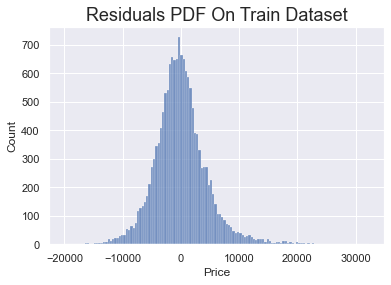

In [57]:
# useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.histplot(y_train - y_hat)
plt.title('Residuals PDF On Train Dataset', size=18)
# In the best case scenario this plot should be normally distributed
# long left tail means over predition
# long right tail implies under prediction

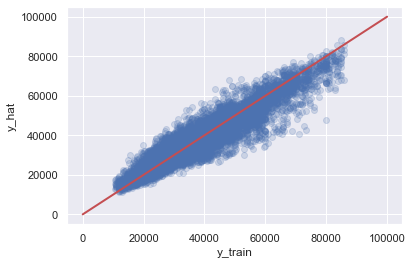

In [58]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat, alpha=0.2)
plt.xlabel('y_train')
plt.ylabel('y_hat')
plt.plot([0, 100000], [0, 100000], color = 'r', linewidth = 2)
plt.show()

In [59]:
# construct model performance evaluation dataframe
performance_train_dataset = backup_X_train.copy()
y_train_difference_percentage = abs(y_train - y_hat)*100/y_train
performance_train_dataset['y_train'] = y_train
performance_train_dataset['y_hat'] = y_hat
performance_train_dataset['y_train_difference(%)'] = y_train_difference_percentage

In [60]:
performance_train_dataset.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_train,y_hat,y_train_difference(%)
16668,Honda,Ridgeline,TRUCKS,Used,Silver,NaN,Automatic,Gasoline,Indianapolis,46227,22386.0,6.0,4.0,18.0,25.0,3,37203.0,38029.176121,2.220724
17823,BMW,430i,CONVERT,Used,White,Black Sensatec,Automatic,Gasoline,San Francisco,94103,588.0,4.0,2.0,24.0,33.0,1,58877.0,47839.650506,18.746454
11903,Ford,Fusion,SEDAN,Used,NaN,NaN,Automatic,Gasoline,Portland,97080,57249.0,4.0,2.0,23.0,34.0,4,18653.0,22027.611775,18.091523
4202,Hyundai,Elantra,SEDAN,Used,Blue,Gray,Automatic,Gasoline,Dallas,75006,18132.0,4.0,2.0,30.0,40.0,2,23902.0,23359.599778,2.269267
1593,GMC,Canyon,TRUCKS,Used,Brown,Cocoa/Dune,Automatic,Gasoline,San Diego,91950,27155.0,6.0,2.0,18.0,25.0,6,35711.0,34111.752368,4.478305


In [61]:
# check data for which model fitting is poor
performance_train_dataset.sort_values(by=['y_train_difference(%)'], ascending=False).head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_train,y_hat,y_train_difference(%)
1878,Ford,Fiesta,SEDAN,Used,Black,Charcoal Black,NaN,Gasoline,Chicago,60546,12813.0,4.0,2.0,NaN,NaN,3,15477.0,30176.993175,94.979603
8677,FIAT,500,HATCH,Used,NaN,NaN,Automatic,Gasoline,Houston,77054,23162.0,4.0,2.0,24.0,32.0,4,14991.0,27271.937419,81.922069
16238,Lexus,ES 350,SEDAN,Used,NaN,Other,Automatic,Gasoline,Phoenix,85226,31210.0,6.0,2.0,21.0,30.0,4,19685.0,35213.649391,78.885697
2581,FIAT,500,HATCH,Used,Gray,Black,Single-Speed,Electric,Los Angeles,90706,14204.0,NaN,2.0,NaN,NaN,4,13288.0,22560.868832,69.783781
3889,Chevrolet,Spark,HATCH,Used,Black,Black,Automatic,Gasoline,Austin,78753,12759.0,4.0,2.0,30.0,38.0,3,15350.0,25954.374442,69.083873


In [62]:
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_hat))
nrmse_train = rmse_train/abs(y_train.max() - y_train.min())
print('Normalized RMSE (NRMSE) of trained dataset: {:.3f}'.format(nrmse_train))

Normalized RMSE (NRMSE) of trained dataset: 0.060


### Model performance metrics for test dataset

In [63]:
# Before Testing
# X_test and X_train should be of same data format
# dealing with missing categorical features in X_test
# dealing with missing numerical features in X_test using transform method
# get dummies for categorical features of X_test
# feature scale the numerical features of X_test using the transform method
# keep only thore columns in X_test as that of X_train

In [64]:
X_test.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age
11192,Subaru,Impreza,SEDAN,Certified,Blue,Black,Automatic,Gasoline,New York,11372,13903.0,4.0,4.0,28.0,38.0,3
17795,BMW,330i,SEDAN,Used,White,Cognac Vernasca Leather,Automatic,Gasoline,San Francisco,94103,9746.0,4.0,2.0,26.0,36.0,1
344,Ford,Edge,SUV,Used,Black,Dune,Automatic,Gasoline,San Antonio,78219,54033.0,4.0,2.0,20.0,29.0,4
16862,Chevrolet,Cruze,SEDAN,Used,Red,Jet Black,Automatic,Gasoline,Indianapolis,46038,29226.0,4.0,2.0,29.0,40.0,4
16575,Jeep,Grand Cherokee,SUV,Used,Gray,Black,Automatic,Gasoline,Phoenix,85014,50001.0,6.0,4.0,18.0,25.0,2


In [65]:
Check_Missing_Values(X_test)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,79,2.06,object
Interior_Color,152,3.96,object
Transmission_Type,10,0.26,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,object


In [66]:
# replace missing categorical variables with the object Missing_Value_XYZ
X_test['Exterior_Color'] = X_test['Exterior_Color'].fillna('Missing_Value_EC')
X_test['Interior_Color'] = X_test['Interior_Color'].fillna('Missing_Value_IC')
X_test['Transmission_Type'] = X_test['Transmission_Type'].fillna('Missing_Value_TT')

In [67]:
# now impute the X_test with the same model that was used to impute the X_train
X_test[['Cylinder_Number', 'Wheel_Drive_Number']] = imputer_frequent.transform(X_test[['Cylinder_Number', 'Wheel_Drive_Number']])
X_test[['MPG_City', 'MPG_Highway']] = imputer_median.transform(X_test[['MPG_City', 'MPG_Highway']])
X_test[['Mileage']] = imputer_mean.transform(X_test[['Mileage']])

In [68]:
# get dummies for the categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [69]:
print(X_train.shape)
print(X_test.shape)

(15338, 15)
(3835, 1470)


In [70]:
# only keep the columns same as X_train in X_test
X_train_feature_list = X_train.columns.values.tolist()
X_test = X_test[X_train_feature_list]

In [71]:
print(X_train.shape)
print(X_test.shape)

(15338, 15)
(3835, 15)


In [72]:
X_test.head()

,Brand_Tesla,Brand_BMW,Brand_Mercedes-Benz,Wheel_Drive_Number,Mileage,Brand_Lexus,MPG_Highway,Body_TRUCKS,Cylinder_Number,Brand_Land Rover,Fuel_Type_Gasoline,Car_Age,Brand_Porsche,Body_SUV,Brand_Audi
11192,0,0,0,4.0,13903.0,0,38.0,0,4.0,0,1,3,0,0,0
17795,0,1,0,2.0,9746.0,0,36.0,0,4.0,0,1,1,0,0,0
344,0,0,0,2.0,54033.0,0,29.0,0,4.0,0,1,4,0,1,0
16862,0,0,0,2.0,29226.0,0,40.0,0,4.0,0,1,4,0,0,0
16575,0,0,0,4.0,50001.0,0,25.0,0,6.0,0,1,2,0,1,0


In [73]:
y_pred = randomized_search_cv.predict(X_test)

Text(0.5, 1.0, 'Residuals PDF On Test Dataset')

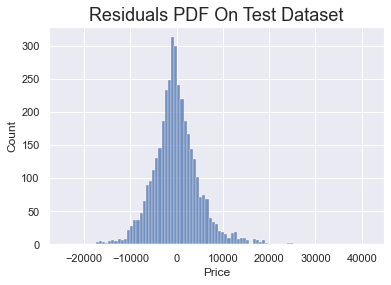

In [74]:
# useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.histplot(y_test - y_pred)
plt.title('Residuals PDF On Test Dataset', size=18)
# In the best case scenario this plot should be normally distributed
# long left tail means over predition
# long right tail implies under prediction

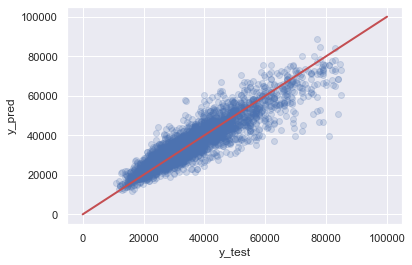

In [75]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot([0, 100000], [0, 100000], color = 'r', linewidth = 2)
plt.show()

In [76]:
# construct model performance evaluation dataframe
performance_test_dataset = backup_X_test.copy()
y_test_difference_percentage = abs(y_test - y_pred)*100/y_test
performance_test_dataset['y_test'] = y_test
performance_test_dataset['y_pred'] = y_pred
performance_test_dataset['y_test_difference(%)'] = y_test_difference_percentage

In [77]:
performance_test_dataset.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_test,y_pred,y_test_difference(%)
11192,Subaru,Impreza,SEDAN,Certified,Blue,Black,Automatic,Gasoline,New York,11372,13903.0,4.0,4.0,28.0,38.0,3,23889.0,26486.264885,10.872221
17795,BMW,330i,SEDAN,Used,White,Cognac Vernasca Leather,Automatic,Gasoline,San Francisco,94103,9746.0,4.0,2.0,26.0,36.0,1,40795.0,44523.206778,9.138882
344,Ford,Edge,SUV,Used,Black,Dune,Automatic,Gasoline,San Antonio,78219,54033.0,4.0,2.0,20.0,29.0,4,27888.0,24663.536584,11.562190
16862,Chevrolet,Cruze,SEDAN,Used,Red,Jet Black,Automatic,Gasoline,Indianapolis,46038,29226.0,4.0,2.0,29.0,40.0,4,17200.0,21941.601545,27.567451
16575,Jeep,Grand Cherokee,SUV,Used,Gray,Black,Automatic,Gasoline,Phoenix,85014,50001.0,6.0,4.0,18.0,25.0,2,39998.0,40095.789919,0.244487


In [78]:
# check data for which model fitting is poor
performance_test_dataset.sort_values(by=['y_test_difference(%)'], ascending=False).head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_test,y_pred,y_test_difference(%)
5658,Dodge,Challenger,COUPE,Used,Blue,Dark Slate Gray,Manual,Gasoline,Washington,22207,10560.0,8.0,2.0,15.0,23.0,9,24800.0,44123.679231,77.918061
16275,Mitsubishi,Outlander,SUV,Used,Black,Black,Single-Speed,Hybrid Gas/Electric,Phoenix,85251,7265.0,NaN,4.0,26.0,26.0,1,33500.0,57801.170202,72.540807
5564,GMC,Terrain,SUV,Used,Red,Jet Black,Automatic,Gasoline,Washington,20740,12790.0,6.0,4.0,16.0,23.0,5,24000.0,40912.418226,70.468409
18676,Dodge,Challenger,COUPE,Used,Blue,Black,Manual,Gasoline,Fort Worth,76180,8140.0,8.0,2.0,15.0,23.0,4,33991.0,57383.220044,68.818864
16174,FIAT,500,HATCH,Used,Gray,Black,Single-Speed,Electric,Phoenix,85015,23661.0,NaN,2.0,NaN,NaN,4,12573.0,20915.253197,66.350538


In [79]:
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
nrmse_test = rmse_test/abs(y_test.max() - y_test.min())
print('Normalized RMSE (NRMSE) of test dataset: {:.3f}'.format(nrmse_test))

Normalized RMSE (NRMSE) of test dataset: 0.072


In [80]:
# difference between nrmse_train and nrmse_test
nrmse_difference = (nrmse_test - nrmse_train)*100/nrmse_train
print('Best score of the model on training dataset: {:.3f}'.format(model_best_score))
print('Normalized RMSE (NRMSE) of trained dataset: {:.3f}'.format(nrmse_train))
print('Normalized RMSE (NRMSE) of test dataset: {:.3f}'.format(nrmse_test))
print('Difference between nrmse_train and nrmse_test: {:.2f} %'.format(nrmse_difference))

Best score of the model on training dataset: 0.829
Normalized RMSE (NRMSE) of trained dataset: 0.060
Normalized RMSE (NRMSE) of test dataset: 0.072
Difference between nrmse_train and nrmse_test: 19.26 %
